In [2]:
%matplotlib inline

In [36]:
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from nltk.corpus import stopwords

In [29]:
# import nltk
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/bartek/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
df = pd.read_csv('messages.csv').dropna()
df['time'] = df["time"].astype("datetime64")
df.head()

,sender_name,time,content
0,Rafał Kulawiak,2012-03-05 14:21:34,będe chyba musiał sformatować komputer
1,Rafał Kulawiak,2012-03-05 14:20:54,nie ściągaj tego
2,Rafał Kulawiak,2012-03-05 14:20:52,sorry samo sie wysłało
3,Klaudia Sałamacha,2012-03-05 14:20:28,hei . Co to ?;]
4,Bartek Paszko,2013-10-22 18:48:40,ok narazie ;D


In [5]:
df = df[df['time'] > '2018-01-01']
my_df = df[df['sender_name'] == 'Bartek Paszko']
len(my_df)

72346

In [6]:
my_df.head()

,sender_name,time,content
359,Bartek Paszko,2019-03-09 18:07:16,o której mniej więcej?
360,Bartek Paszko,2019-03-09 18:07:09,"ok, thx za info"
362,Bartek Paszko,2019-03-04 21:16:33,Jest awizo
363,Bartek Paszko,2019-03-02 22:59:40,a dzisiaj rano ostatni raz sprawdzałem i nie b...
364,Bartek Paszko,2019-03-02 22:59:17,"jakiś czas temu przyszedł, ale to Darek wrócił..."


In [18]:
def analyse_xd(df):
    pattern = r'([xX]+[dD]+)'
    content = df['content']
    xds = df['content'].str.extractall(pattern)# .unstack() #.apply(','.join, 1)
    xds = xds.reset_index(drop=True)[0]
    return xds.value_counts(), xds.apply(lambda x: len(x)).mean()


def analyse_xd_via_time(df):
    df = df.copy()
    pattern = r'([xX]+[dD]+)'
    content = df['content']
    xds = df['content'].str.extractall(pattern)# .unstack() #.apply(','.join, 1)
    
    l = []
    indices = [i[0] for i in xds.index.values]
    for i, _ in tqdm(df.iterrows(), total=len(df)):
        if i in indices:
            l.append(1)
        else:
            l.append(0)
            
    df['xd'] = l
    df = df[['time', 'xd']]
    return df.groupby(df["time"].dt.hour).sum()

In [64]:
from collections import Counter

def most_common_words(df, n=-1):
    to_delete = ['wysłałeś', 'zdjęcie', '']
    stop = stopwords.words('polish')
    c = Counter()
    
    def update_counter(msg):
        msg = msg.lower().translate(str.maketrans('', '' , ',."\'?!')).split(' ')
        c.update(msg)
        
    df['content'].apply(update_counter)
    
    for drop_w in itertools.chain(stop, to_delete):
            c.pop(drop_w, None)
    
    for k in list(c.keys()):
            if k.isnumeric():
                c.pop(k, None)
    
    return c if n == -1 else c.most_common(n)
    

In [75]:
def average_msg_len(df):
    lengths = df['content'].apply(lambda x: len(x))
    return lengths

In [18]:
def msg_per_hour(df):
    return df['time'].groupby(df["time"].dt.hour).count()

def msg_per_day(df):
    mapping = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }
    weekdays = df['time'].apply(lambda x: mapping[x.weekday()])
    return weekdays.value_counts()

In [60]:
def swear_percent(df, swear_list):
    emotes = ['xd', 'xdd', 'xddd', ':)', ':(', ':c', '<3', ';)', ';(', ';c', ';*', ':*', '^^', ';>', ':>', 
              ';<', ':<', ':d', ';d', ':p', ';p', ';]', ':]', ';[', ':[', '-.-' '^.^', '*.*',
              ':\\', ';\\', ':/', ';/', ':-)', ';-)', ':-/', ';-/']
    
    c = most_common_words(df)
    for emote in emotes:
        c.pop(emote, None)
              
    swears, total = 0, sum(c.values())
    for swear in swear_list:
        if swear in c:
            swears += c[swear]
    return swears / total

In [65]:
with open('wulgaryzmy.txt') as f:
    swear_list = f.read().split(' ')

swear_percent(my_df, swear_list)

0.025057312386218056

#### Rozkład wysyłanych wiadomości godzinowo

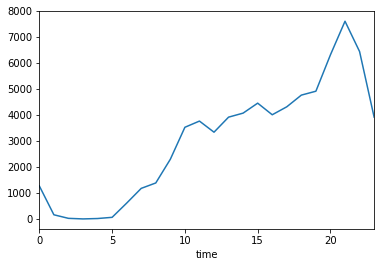

In [12]:
hist_hour = msg_per_hour(my_df)
hist_hour.plot()

#### Rozkład wysyłanych wiadomości dziennie

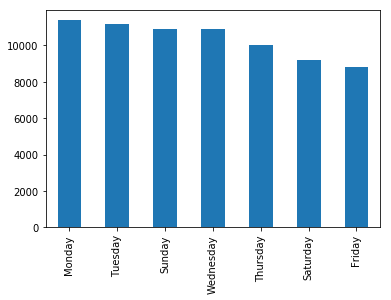

In [19]:
weekdays = msg_per_day(my_df)
weekdays.plot(kind='bar')

#### Najczęstsze rodzaje wysyłanego xD

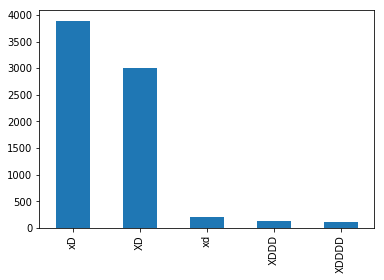

In [27]:
xds_counts, mean_xd_len = analyse_xd(my_df)
xds_counts[:5].plot(kind='bar')

#### ilość XD per godzina

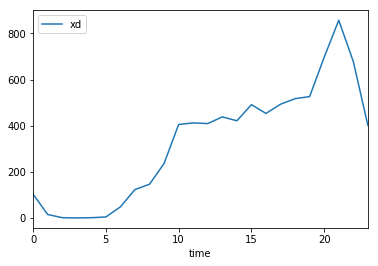

In [19]:
xd_time = analyse_xd_via_time(my_df)
xd_time.plot()

#### Najczęściej występujące słowa

In [66]:
mcw = most_common_words(my_df, n=50)
for w, c in mcw:
    print(f'{w}\t\t{c}')

xd		7105
:d		2093
:c		1623
lel		1622
;*		1571
dawit		1197
kurwa		1010
jutro		911
masz		672
pewnie		626
dawaj		619
ech		611
chce		570
wiem		565
zaraz		544
chyba		533
dobra		503
nom		492
dejw		467
idę		457
bym		451
pracy		417
<3		414
spoko		391
czego		360
:)		359
potem		350
chuj		322
k		314
będziesz		292
możesz		270
trochę		269
wat		269
muszę		261
jesteś		253
pora		252
:(		249
chcesz		241
ez		238
spać		235
jakieś		234
ok		230
polecam		223
musisz		218
xddd		218
wgl		214
domu		212
mogę		210
dopiero		209
only		209


#### Średnia długość wiadomości (w znakach) - wyrzucone outliery

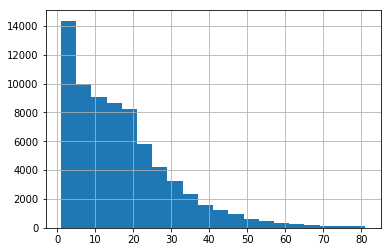

In [91]:
lengths = average_msg_len(my_df)
lengths[~((lengths-lengths.mean()).abs() > 3*lengths.std())].hist(bins=20)